In [68]:
%load_ext line_profiler
import line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [1]:
import os 
import importlib
import sys
import tensorflow as tf
import itertools
import numpy as np
import numba as nb
from math import sqrt, log, exp
from numpy import unravel_index
from random import choice, random, sample
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential, Model, load_model
import keras.backend as K
import matplotlib.pyplot as plt
K.set_image_dim_ordering('th')
import time

Using TensorFlow backend.


In [2]:
def get_policy_dict_list():
    '''Get the relation between policy no. and policy'''
    index=0
    policy_dict = {}
    policy_list = []
    for r in range(7):
        for c in range(7):
            for dr in range(-2, 3):
                for dc in range(-2, 3):
                    new_r = r + dr
                    new_c = c + dc
                    if (dr != 0 or dc != 0) and (new_r < 7 and new_r >= 0) and (new_c < 7 and new_c >= 0):
                        policy_dict[((r, c), (new_r, new_c))] = index
                        policy_list.append(((r, c), (new_r, new_c)))
                        index += 1
    return policy_dict, policy_list

policy_dict, policy_list = get_policy_dict_list()

In [97]:
def g():
    for i in range(3):
        yield i
    
for i in g():
    print(i)

0
1
2


In [98]:
def assign_children(children, p_array):
    for move in children:
        children[move] = np.float32(p_array[policy_dict[move]])

class Ataxx:
    def __init__(self, board=None):
        if board is None:                  # if there is no initialization given
            self.data = np.zeros((7, 7), dtype=np.int8)   # then generate a board with starting init, and black(-1) takes first turn
            self.data[0, 0] = -1           
            self.data[6, 6] = -1
            self.data[0, 6] = 1
            self.data[6, 0] = 1
        else:
            self.data = board.copy()
            
    def reset(self, board=None):
        if board is None:
            self.data = np.zeros((7, 7), dtype=np.int8)
            self.data[0, 0] = -1           
            self.data[6, 6] = -1
            self.data[0, 6] = 1
            self.data[6, 0] = 1
        else:
            self.data = board.copy()
        
    def get_feature_map(self, turn, move):
        out = np.zeros((6, 9, 9), dtype=np.int8)
        # define 1 edge
        
        # edge
        for j in range(9):
            for k in range(9):
                if j == 0 or j == 8 or k == 0 or k == 8:
                    out[0, j, k] = 1
         
        # my pieces
        for j in range(9):
            for k in range(9):
                if j > 0 and j < 8 and k > 0 and k < 8:
                    if self.data[j-1, k-1] == turn:
                        out[1, j, k] = 1
        
        # op pieces
        for j in range(9):
            for k in range(9):
                if j > 0 and j < 8 and k > 0 and k < 8:
                    if self.data[j-1, k-1] == -turn:
                        out[2, j, k] = 1
         
        # last move
        if not move is None:               
            out[3, move[0][0]+1, move[0][1]+1] = 1
            out[4, move[1][0]+1, move[1][1]+1] = 1
            
        # whose first
        if turn == -1:
            for j in range(9):
                for k in range(9):
                    out[5, j, k] = 1
        return np.array(out)
    
    def plot(self, is_next_move=False, turn=None):                        # plot the board
        image = self.data.copy()
        if is_next_move:
            if turn not in [-1, 1]:
                raise ValueError("Turn must be -1 or 1, or Must input a turn for next moves")
            else:
                next_moves = self.get_moves(turn)
                if len(next_moves) == 0:
                    raise ValueError("Game is over already")
                next_pos = list(zip(*next_moves))[1]
                for pos in next_pos:
                    image[pos] = turn / 2
        plt.imshow(image, cmap='gray')
        plt.xticks(range(7), range(7))
        plt.yticks(range(7), range(7))
        plt.show()
        
    def get_greedy_move(self, turn, moves=None):
        best_score = -50
        # get all possible moves if not provided
        if moves is None:
            moves, corr_dict, _, _ = self.get_moves(turn, return_node_info=True)
            for item in corr_dict:
                moves.append(item)
        
        if len(moves) == 0:
            raise ValueError('No Possible Moves')
        
        best_moves = []
        # calculate greedy move
        for (x0, y0), (x1, y1) in moves:
            tmp_score = 0
            if abs(x0-x1) <= 1 and abs(y0-y1) <= 1:
                tmp_score += 1
            for dr in range(-1, 2):
                for dc in range(-1, 2):
                    try:
                        if x1+dr >= 0 and y1+dc >= 0:
                            tmp_score += self.data[x1+dr, y1+dc] == -turn
                    except:
                        pass
            if tmp_score > best_score:
                best_moves = [((x0, y0), (x1, y1))]
                best_score = tmp_score
            elif tmp_score == best_score:
                best_moves.append(((x0, y0), (x1, y1)))
        return choice(best_moves)
                
    def is_valid(self, turn, pos, get_pos=False):
        r = pos[0]
        c = pos[1]
        if self.data[r, c] != 0:
            if not get_pos:
                return False
            else:
                return
        else:
            for dr in range(-2, 3):
                for dc in range(-2, 3):
                    new_r = r+dr
                    new_c = c+dc
                    if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7 and self.data[new_r, new_c] == turn:
                        if not get_pos:
                            return True
                        else:
                            yield new_r, new_c, dr, dc
            if not get_pos:
                return False
        
    def get_moves(self, turn, return_node_info=False):
        action_mask = np.zeros(792, dtype=np.int8)
        next_moves = []
        corr_dict = {}
        children_dict = {}
        for r in range(7):
            for c in range(7):
                has_duplicate_move = False      # move within the radius of one of another friendly piece is called
                for new_r, new_c, dr, dc in self.is_valid(turn, (r, c), True): # duplicate move
                    if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7 and self.data[new_r, new_c] == turn:
                        if abs(dr) <= 1 and abs(dc) <=1:
                            if has_duplicate_move: 
                                cur_move = ((new_r, new_c), (r, c))
                                corr_dict[cur_move] = dup_move
                                # update action mask
                                if return_node_info: 
                                    action_mask[policy_dict[cur_move]] = 1
                            elif self.data[new_r, new_c] == turn:
                                dup_move = ((new_r, new_c), (r, c))
                                next_moves.append(dup_move) 
                                has_duplicate_move = True
                                # preparing children nodes and action mask
                                if return_node_info: 
                                    children_dict[dup_move] = None
                                    action_mask[policy_dict[dup_move]] = 1
                        elif self.data[new_r, new_c] == turn:
                            cur_move = ((new_r, new_c), (r, c))
                            next_moves.append(cur_move) 
                            # preparing children nodes and action mask
                            if return_node_info:
                                children_dict[cur_move] = None
                                action_mask[policy_dict[cur_move]] = 1
                        else:
                            continue
        if return_node_info:
            return next_moves, corr_dict, children_dict, np.array(action_mask)
        else:
            return next_moves
        
    def move_to(self, turn, pos0, pos1):
        x0 = pos0[0]
        y0 = pos0[1]
        x1 = pos1[0]
        y1 = pos1[1]
        
        if not self.is_valid(turn, pos1):
            raise ValueError("This move: " + str((pos0, pos1)) + " of turn: " + str(turn) + " is invalid") 
        elif self.data[x0, y0] != turn:
            raise ValueError("The starting position is not your piece")
        else:
            self.data[x1, y1] = turn
            if abs(x0 - x1) > 1 or abs(y0 - y1) > 1:   # jump move
                self.data[x0, y0] = 0

            for dr in range(-1, 2):                  # infection mode!!!!
                for dc in range(-1, 2):
                    if x1+dr >= 0 and y1+dc >= 0 and x1+dr < 7 and y1+dc < 7:
                        if self.data[x1+dr, y1+dc] == -turn:  # convert any piece of the opponent to 'turn'
                            self.data[x1+dr, y1+dc] = turn
    
    def evaluate(self, turn, this_turn, max_score=1, min_score=0.001):
        turn_no=0
        op_no=0
        for r in range(7):
            for c in range(7):
                if self.data[r, c] == turn:
                    turn_no += 1
                elif self.data[r, c] == -turn:
                    op_no += 1
        if len(self.get_moves(this_turn)) == 0:# if one of them can no longer move, count and end
            if turn_no > op_no:
                return max_score
            else:
                return -max_score
        else:
            value = turn_no - op_no
        return value * min_score
    
    @staticmethod    
    def get_manual_q(turn, board):
        '''consider linear growth of win prob with regard to n_diff
        when diff >= 10, the slope grow a bit
        when diff >= 35, consider win prob close to 1 or -1
        ''' 
        turn_no = 0
        op_no = 0
        max1=0.9
        max2=0.95
        # get no diff of turns
        for r in range(7):
            for c in range(7):
                if board[r, c] == turn:
                    turn_no += 1
                elif board[r, c] == -turn:
                    op_no += 1
        diff = turn_no - op_no
        if abs(diff) > 30:
            return diff / abs(diff)
        else:
            return diff / 30
        
        # ignore the rest for now
        sign = diff
        diff = abs(diff)
        if diff < 35:
            diff = (diff / 35) ** 2 * max1
        else:
            diff = max2

        if sign < 0:
            return -diff
        else:
            return diff

In [99]:
'''These methods are for Min max'''
def evaluate(board, turn):
    turn_no = 0
    op_no = 0
    # get no diff of turns
    for r in range(7):
        for c in range(7):
            if board[r, c] == turn:
                turn_no += 1
            elif board[r, c] == -turn:
                op_no += 1
    return (turn_no - op_no)
        
def is_valid(board, turn, pos):
    r = pos[0]
    c = pos[1]
    if board[r, c] != 0:
        return False
    else:
        for dr in range(-2, 3):
            for dc in range(-2, 3):
                new_r = r+dr
                new_c = c+dc
                if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7 and board[new_r, new_c] == turn:
                    return True
        return False 
    

def next_move(board, turn):
    next_moves = []
    for r in range(7):
        for c in range(7):
            has_duplicate_move = False      # move within the radius of one of another friendly piece is called
            if is_valid(board, turn, (r, c)): # duplicate move
                for dr in range(-2, 3):
                    for dc in range(-2, 3):
                        new_r = r+dr
                        new_c = c+dc
                        if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7 and board[new_r, new_c] == turn:
                            if abs(dr) <= 1 and abs(dc) <=1:
                                if board[new_r, new_c] == turn and not has_duplicate_move:
                                    dup_move = ((new_r, new_c), (r, c))
                                    has_duplicate_move = True
                                    yield dup_move
                            elif board[new_r, new_c] == turn:
                                cur_move = ((new_r, new_c), (r, c))
                                yield cur_move
                            else:
                                continue

def has_next_move(board, turn):
    try:
        next(next_move(board, turn))
        return True
    except StopIteration:
        return False
                                
def move_to(board, turn, pos0, pos1):
    x0 = pos0[0]
    y0 = pos0[1]
    x1 = pos1[0]
    y1 = pos1[1]

    if not is_valid(board, turn, pos1):
        raise ValueError("This move: " + str((pos0, pos1)) + " of turn: " + str(turn) + " is invalid") 
    elif board[x0, y0] != turn:
        raise ValueError("The starting position is not your piece")
    else:
        board = board.copy()
        board[x1, y1] = turn
        if abs(x0 - x1) > 1 or abs(y0 - y1) > 1:   # jump move
            board[x0, y0] = 0

        for dr in range(-1, 2):                  # infection mode!!!!
            for dc in range(-1, 2):
                if x1+dr >= 0 and y1+dc >= 0 and x1+dr < 7 and y1+dc < 7:
                    if board[x1+dr, y1+dc] == -turn:  # convert any piece of the opponent to 'turn'
                        board[x1+dr, y1+dc] = turn
        return board
    
def min_max(board, turn, target_turn, depth=3, alpha=-100, beta=100, is_max=True, is_root=True):
    '''A recursive alpha beta pruning min_max function
    return: board evaluation, chosen move
    NB. for board evaluation, if the searching was pruned, it will return 100 for a minimizer and -100 for a maximizer'''
    if is_root:
        best_moves = []
    else:
        best_move = ((0, 0), (0, 0))
    
    if depth == 0 or not has_next_move(board, turn): # start to do pruning and selecting once the recursion reaches the end
        result = evaluate(board, target_turn)
        return result, None
    else:
        if is_max:
            alpha = -100
        else:
            beta = 100

        for move in next_move(board, turn):
            result, _ = min_max(move_to(board, turn, move[0], move[1]), \
                                -turn, target_turn, depth-1, alpha, beta, not is_max, False)
            # prun the searching tree or update alpha and beta respectively
            if is_max:
                if result >= beta:
                    return 100, None
                elif result > alpha:
                    alpha = result
                    if is_root:
                        best_moves = [move]
                    else:
                        best_move = move
                elif result == alpha and is_root:
                    best_moves.append(move)
            else:
                if result <= alpha:
                    return -100, None
                elif result < beta:
                    beta = result
                    if is_root:
                        best_moves = [move]
                    else:
                        best_move = move
                elif result == beta and is_root:
                    best_moves.append(move)
        if is_max:
            if is_root:
                return alpha, choice(best_moves)
            else:
                return alpha, best_move
        else:
            if is_root:
                return beta, choice(best_moves)
            else:
                return beta, best_move

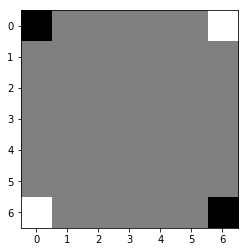

depth 3 move takes time:  0.20711016654968262


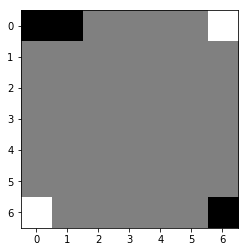

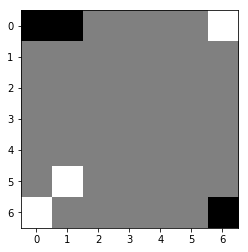

depth 3 move takes time:  0.4131450653076172


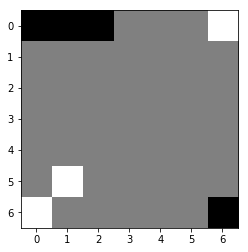

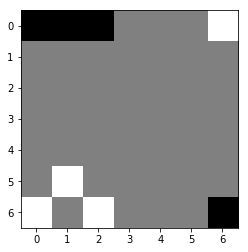

depth 3 move takes time:  0.9740967750549316


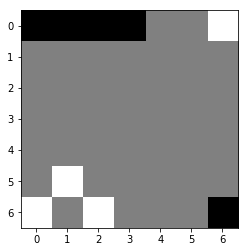

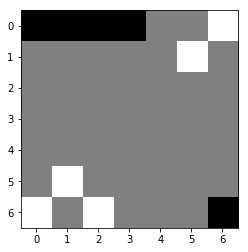

depth 3 move takes time:  0.5573279857635498


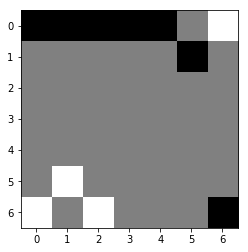

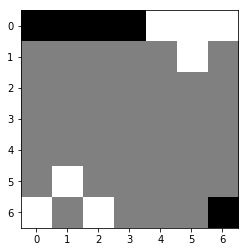

depth 3 move takes time:  0.3275899887084961


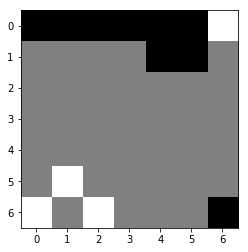

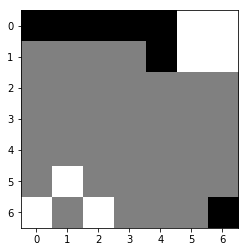

depth 3 move takes time:  1.0497159957885742


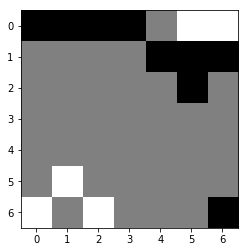

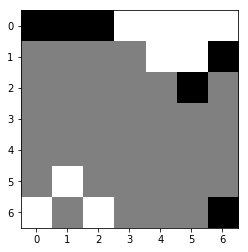

depth 3 move takes time:  0.9246079921722412


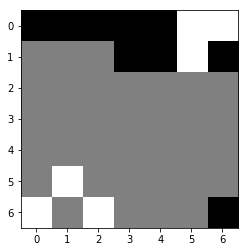

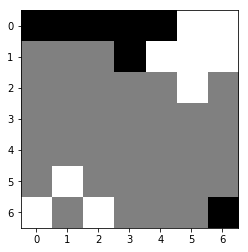

depth 3 move takes time:  0.9986989498138428


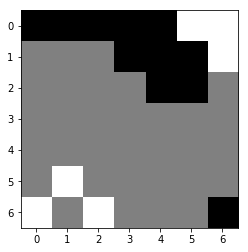

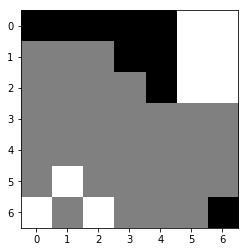

depth 3 move takes time:  1.0953969955444336


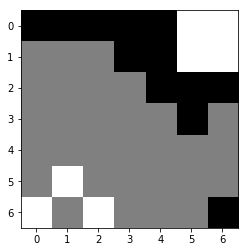

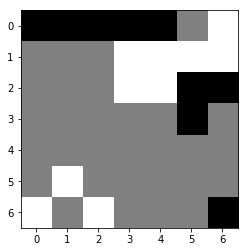

depth 3 move takes time:  0.6730899810791016


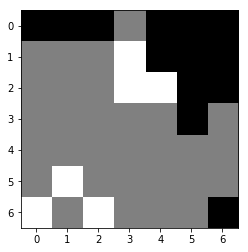

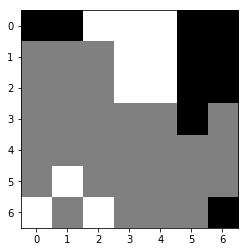

depth 3 move takes time:  0.607295036315918


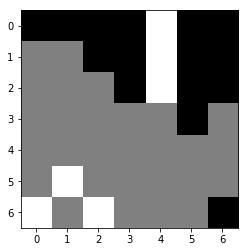

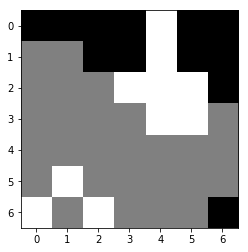

depth 3 move takes time:  1.0316860675811768


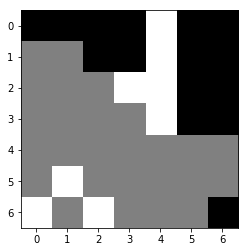

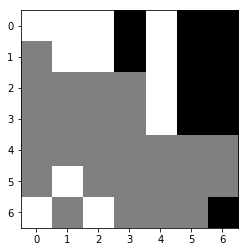

depth 3 move takes time:  1.0200650691986084


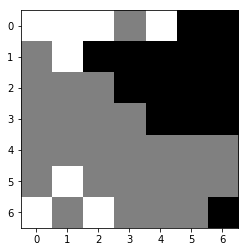

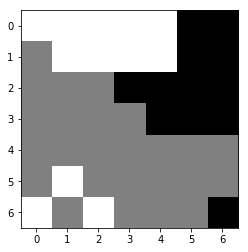

depth 3 move takes time:  1.8952951431274414


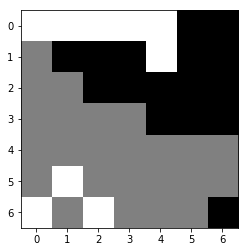

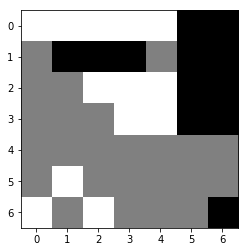

depth 3 move takes time:  0.9080698490142822


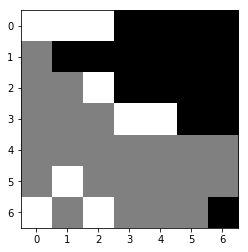

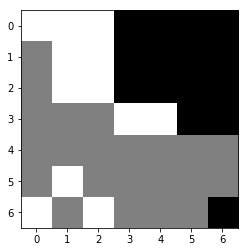

depth 3 move takes time:  1.068674087524414


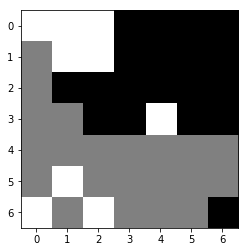

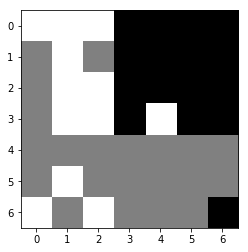

depth 3 move takes time:  1.3652808666229248


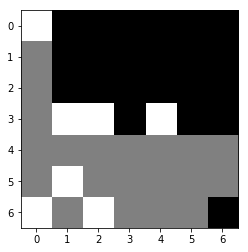

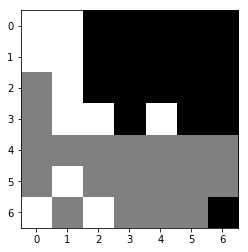

depth 3 move takes time:  1.6618518829345703


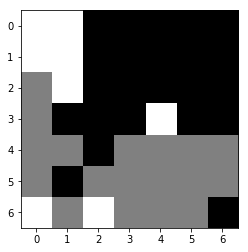

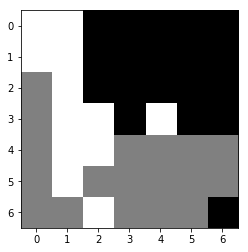

depth 3 move takes time:  1.3777880668640137


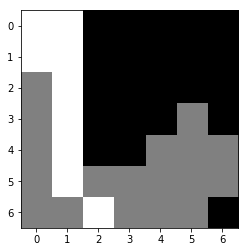

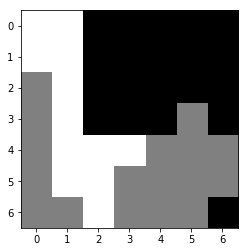

depth 3 move takes time:  1.7872381210327148


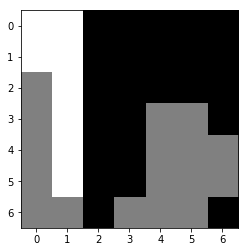

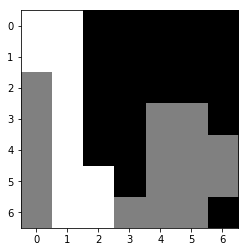

depth 3 move takes time:  3.4604239463806152


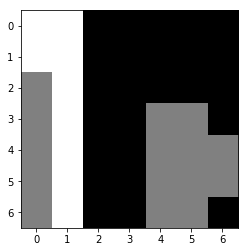

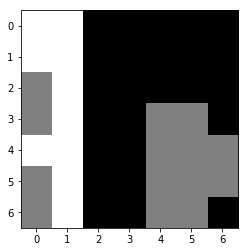

depth 3 move takes time:  3.2523880004882812


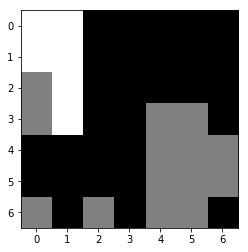

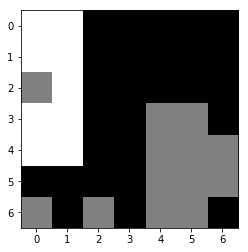

depth 3 move takes time:  2.329195022583008


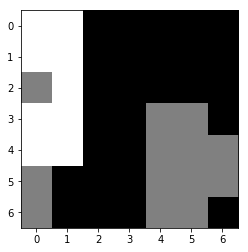

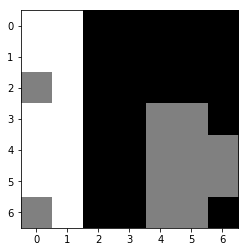

depth 3 move takes time:  1.1462302207946777


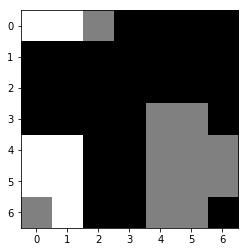

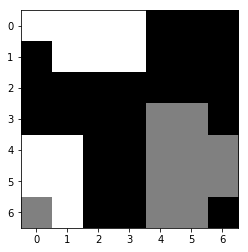

depth 3 move takes time:  1.39540696144104


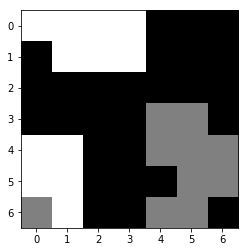

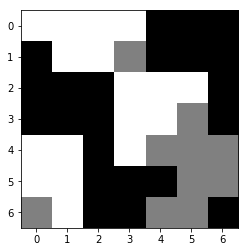

depth 3 move takes time:  0.4424278736114502


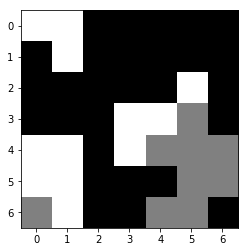

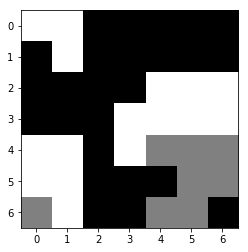

depth 3 move takes time:  0.3285529613494873


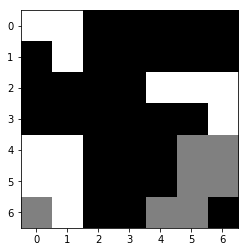

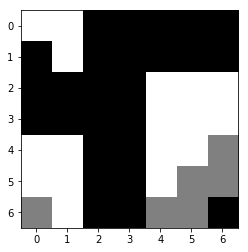

depth 3 move takes time:  0.1870560646057129


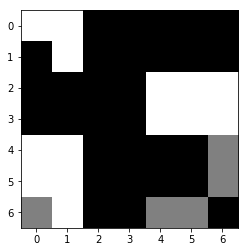

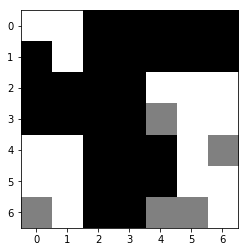

depth 3 move takes time:  0.12183308601379395


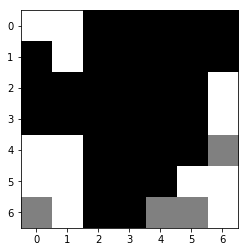

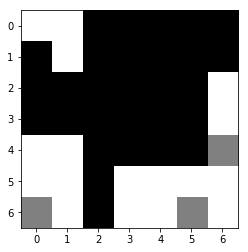

depth 3 move takes time:  0.06844806671142578


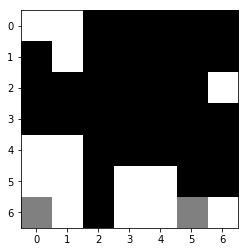

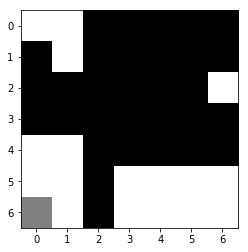

depth 3 move takes time:  0.008214950561523438


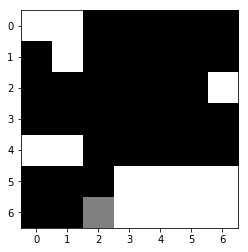

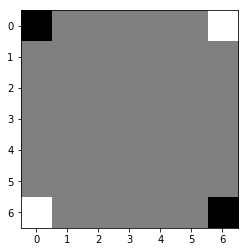

depth 3 move takes time:  0.22047805786132812


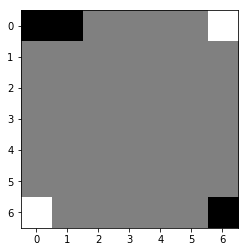

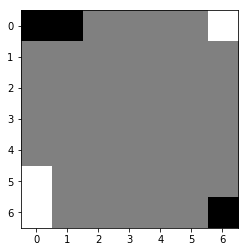

depth 3 move takes time:  0.43213820457458496


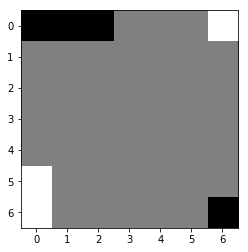

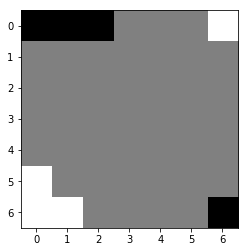

depth 3 move takes time:  0.676461935043335


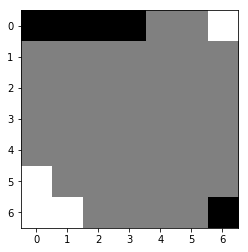

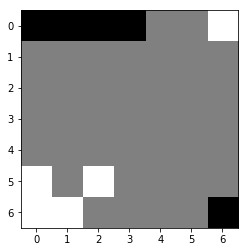

depth 3 move takes time:  0.742440938949585


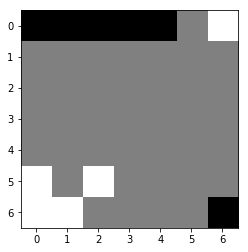

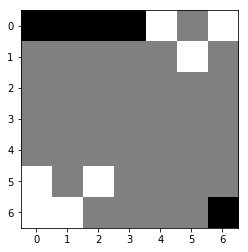

depth 3 move takes time:  0.4732189178466797


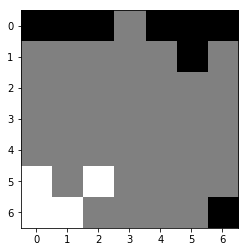

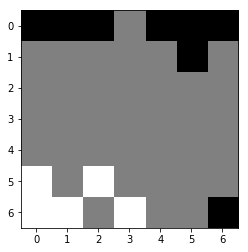

KeyboardInterrupt: 

In [100]:
N = 10
D = 3
greedy_win = 0
time_avg = []
for _ in range(N):
    steps = 0
    a = Ataxx()
    turn = -1
    greedy_turn = choice([-1, 1])
    while True:
        steps += 1
        a.plot()
        if turn == greedy_turn:
            best_move = a.get_greedy_move(turn)
        else:
            s = time.time()
            _, best_move = min_max(a.data, turn, turn, depth=D)
            span = time.time() - s
            print("depth", D, "move takes time: ", time.time()-s)
            if steps > 10 and steps < 60:
                time_avg.append(span)
        a.move_to(turn, best_move[0], best_move[1])
        turn = -turn
        result = a.evaluate(greedy_turn, turn)
        if result == 1:
            greedy_win += 1
            break
        elif result == -1:
            break
print("In the previous ", N, " rounds, greedy win ratio is: ", float(greedy_win) / float(N))
time_avg = np.array(time_avg)
print("On average, for depth", D, \
      ", each move takes time: ", time_avg.mean(),\
      "max time elapsed:", time_avg.max())

In [ ]:
class PolicyValueNetwork():
    def __init__(self):
        self._sess = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=24))
        K.set_session(self._sess)
        
        self._model = load_model('AtaxxZero.h5')
        print("successfully loaded two models")
           
    def predict(self, feature_map, action_mask):        
        return self._sess.run(self._model.outputs, feed_dict={self._model.inputs[0]: feature_map.reshape(-1, 6, 9, 9), \
                                self._model.inputs[1]: action_mask.reshape(-1, 792), K.learning_phase(): 0})

In [ ]:
def for_node(c, parent_n_visit, n_visit, p, q):
    return c * p * sqrt(parent_n_visit + 1) / (n_visit + 1) - q / (n_visit + 1) 

def get_q(init_q, manual_q, mode):
    '''Manual_q and init_q are both an estimation for the q value
    It seems that considering init_q to be a rectification will not lead to good result'''
    if mode == 0:
        return manual_q
    elif mode == 1:
        return init_q
    elif mode == 2:
        return 0.75 * manual_q + 0.25 * init_q
    elif mode == 3:
        if abs(manual_q) >= 0.5:
            return 0.5 * manual_q + 0.5 * init_q 
        elif abs(manual_q) >= 0.8:
            return manual_q
        elif abs(init_q) > 0.15:
            return 0.2 * manual_q + 0.8 * init_q
        elif abs(init_q) > 0.5:
            return init_q
        else:
            return 0.4 * manual_q + 0.6 * init_q
    elif mode == 4:
        if abs(manual_q) >= 0.8:
            return manual_q
        elif abs(manual_q) >= 0.5:
            return 0.5 * manual_q + 0.5 * init_q 
        else:
            return init_q
    else:
        raise ValueError("Mode is not specified")
        
class TreeNode():
    def __init__(self, parent, p=0.0):
        self._parent = parent
        self._children = {} # a dictionary of action:node
        self._corr_dict = {} # a dictionary for duplicated moves
        self._n_visit = 0
        # from the parent perspective
        self._q = 0.0
        self._manual_q = -5 # manually deviced q
        self._init_q = -5 # learnt q
        self._p = p
        self._action_mask = None
        self._feature_map = None
        self._board = None
        self._is_expanded = False
        self._prev_move = None
        
    def __str__(self):
        out = "_n_visit: {}, _q: {}, _p: {}, _children: \n{}".format(\
                self._n_visit, self._q, self._p, self._children)
        return out
    
    def get_start_q(self, mode=0):
        ''' Different mode means different q
        mode 0: pure manual Q
        mode 1: pure policy Q
        mode 2: hybrid Q
        '''
        assert self._init_q != -5 and self._manual_q != -5
        assert self._q == 0
        self._q = get_q(self._init_q, self._manual_q, mode)
    
    def access_children(self, move):
        try:
            return self._children[move]
        except:
            return self._children[self._corr_dict[move]]
    
    def children_generator(self):
        for move in self._children:
            yield (move, self._children[move])
        for move in self._corr_dict:
            yield (move, self._children[self._corr_dict[move]])
    
    def update_all(self, t_v):
        node = self
        while not node is None: 
            node._q += t_v
            node._n_visit += 1
            node = node._parent
            t_v = -t_v
            
    @staticmethod
    def get_search_value(parent, node, c):
        # return values 
        try:
            value = for_node(c, parent._n_visit, node._n_visit, node._p, node._q)
        except:
            print(parent)
            print(node)
            raise
        return value
        
    @staticmethod
    def get_frequency_value(node):
        try:
            return node._n_visit
        except:
            return 0
    
    def select(self, c):
        best_node = [0, 0]
        best_node[0], best_node[1] = max(self._children.items(), key=lambda node: self.get_search_value(self, node[1], c))
        return best_node
        
    def get_action_mask(self):
        # only generate the action mask once
        if not self._action_mask is None:
            return self._action_mask
        else:
            raise ValueError("No action mask, request failure")
    
    def get_action_frequency_map(self, temp=1):
        global policy_dict
        out = np.zeros(len(policy_dict))
        # record all the n_visit of each node
        nodes = self.children_generator()
        for node in nodes:
            out[policy_dict[node[0]]] = (float(node[1]._n_visit) / 100) ** (1/temp)
        # normalize the array
        out /= out.sum()
        return out

In [56]:
class MCTS():
    def __init__(self, c=1, dep_lim=10, mode=1, game=None, turn=-1):
        # slow_step means how many step we use to do typical mcts, after that we do fast play
        self._c = c
        self._dep_lim = dep_lim
        if game is None:
            self._game = Ataxx()
        else:
            self._game = game
        self._turn = turn
        # generate model
        self._network = PolicyValueNetwork()
        # determine which mode to use, default is 0, to switch mode, must do manually
        self._mode = mode
        # generate root and expand initially its children
        self._root = TreeNode(None) # this one will move in self play mode
        self.further_init(self._root, self._game, self._turn, get_p_array=True)
        self._root_store = self._root # this is a backup for reset
        
        
    def reset_root(self, move=None):
        self._root = TreeNode(None) # this one will move in self play mode
        self.further_init(self._root, self._game, self._turn, move, get_p_array=True)
        self._root_store = self._root # this is a backup for reset
        
    def reset(self, left_space=45):
        self._game.reset()
        self._turn = -1
        self._root = TreeNode(None)
        
        if left_space < 45:
            steps = 0
            is_terminal = False
            result = 45
            while not is_terminal and result > left_space:
                if np.random.random() < 0.2: # 80 percent using greedy move
                    best_move = choice(self._game.get_moves(self._turn))
                    
                else:
                    best_move = self._game.get_greedy_move(self._turn)
                    
                self.make_a_move(best_move)
                is_terminal = abs(self._game.evaluate(1, self._turn)) == 1
                result = (np.array(self._game.data) == 0).sum()
                steps += 1
            if is_terminal:
                print("reset failure, do reset again")
                self.reset(left_space)
        self.reset_root()
        try: # tell the _root which move led it here
            self._root._move = best_move
        except:
            pass
        
    def plot_move_visit_freq(self):
        nodes = sorted(self._root._children.items(), key=lambda node: self._root.get_frequency_value(node[1]), reverse=True)
        p_sum = 0
        for node in nodes:
            try:
                print("{}: n_v:{:>6d} q_all:{:+06.6f} q:{:+06.6f} q_m:{:+06.6f} p:{:06.6f}"\
                      .format(node[0], node[1]._n_visit, -node[1]._q / (node[1]._n_visit + 1), \
                              -node[1]._init_q, -node[1]._manual_q, node[1]._p))
                p_sum += node[1]._p
            except:
                pass
        print("########################p_sum is: ", p_sum)
                      
    def get_next_move(self, q_best=True, rollout_times=100, t_lim=np.nan):
        global policy_list
        # do mcts
        self.rollout(rollout_times, t_lim)
        
        if not q_best:
            # return the most frequently visited move
            index = np.argmax(self._root.get_action_frequency_map())
            return policy_list[index]
        else:
            # return the highest q move
            if self._root._n_visit > 8:
                best_q = -5
                best_move = None
                for move, node in self._root._children.items():
                    if node._n_visit > 5 and -node._q / (node._n_visit + 1) > best_q:
                        best_q = -node._q / (node._n_visit + 1)
                        best_move = move

            if best_move is None or self._root._n_visit <= 8:
                print("too few visits, use p policy")
                best_p = 0
                best_move = None
                for move, node in self._root._children.items():
                    if node._p > best_p:
                        best_p = node._p
                        best_move = move
            
            return best_move
            
        
    def make_a_move(self, next_move):
        # move the root to next_move's root
        if self._root._children == {}:
            self._root = TreeNode(None)
        elif type(self._root.access_children(next_move)) is np.float32: # the root may not be neccessarily expanded
            self._root = TreeNode(None)
        else:
            self._root = self._root.access_children(next_move)
            self._root._parent = None # necessary for updata_all
        
        # update the game board
        self._game.move_to(self._turn, next_move[0], next_move[1])
        self._turn = -self._turn
      
    def further_init(self, node, game, turn, prev_move=None, get_p_array=False):
        global policy_dict, policy_list
        node._prev_move = prev_move # tell which move led the node here
        # preparing all children
        new_moves, node._corr_dict, node._children, node._action_mask \
                                = game.get_moves(turn, return_node_info=True)
        # if meet end of the game, generate manual q
        if node._children == {}:
            if node._manual_q == -5:
                node._manual_q = game.get_manual_q(turn, game.data)
            # quite tricky here dude, remember to look from the parent perspective
            if node._manual_q > 0:
                node._q = 1
            else:
                node._q = -1 
            return
        
        # generate feature map
        node._feature_map = game.get_feature_map(turn, prev_move)
        node._board = game.data.copy()
        # if required, generate p array and q, only if there are children
        if get_p_array:
            # generate policy prob array
            out = self._network.predict(node._feature_map, node._action_mask)
            p_array = out[0]
            # give p to each child (float32)
            for move in new_moves:
                node._children[move] = p_array[0][policy_dict[move]]
            # init node._q
            node._init_q = out[1][0][0] 
            node._manual_q = game.get_manual_q(turn, game.data)
            node.get_start_q(self._mode)
        
    def expand(self, node, game, turn):
        global policy_dict, policy_list
        
        # if the node was not expanded, take that as a new root and further init it
        if node._children == {} and node._q == 0:
            self.further_init(node, game, turn, get_p_array=True)
        # if end of game, quit expanding
        if node._children == {}:
            assert node._q != 0
            return
        
        # update expanded state
        node._is_expanded = True
        
        # if there are children
        backup_board = game.data.copy() # warning, to backup a memoryview ndarray, use copy()
        index_list = []
        feature_map = []
        action_mask = []
        boards = []
        for move in node._children:
            tmp = node._children[move]
            try:
                assert type(tmp) is np.float32
            except:
                print(type(tmp))
                raise
            new_node = TreeNode(node, p=node._children[move])
            game.move_to(turn,  move[0], move[1])
            self.further_init(new_node, game, -turn, move, get_p_array=False)
            node._children[move] = new_node
            # prepare to calculate p for new_node only if it has children
            if new_node._children != {}:
                index_list.append(new_node)
                feature_map.append(new_node._feature_map)
                action_mask.append(new_node._action_mask)
                boards.append(new_node._board)
            # reset the gamer
            game.reset(board=backup_board)
        # if there are no more node that is expandable, quit
        if len(index_list) == 0:
            return
        
        # do batch prediction
        # print("batch size:", len(index_list))
        feature_map = np.stack(feature_map, axis=0)
        action_mask = np.stack(action_mask, axis=0)
        out = self._network.predict(feature_map, action_mask)
        # get batch manual q 
        boards = [game.get_manual_q(-turn, board) for board in boards]
        # update the result to each child node
        for i, child in enumerate(index_list):
            # assign q
            child._manual_q = boards[i] # neg for display use
            child._init_q = out[1][i][0] # same as above
            child.get_start_q(self._mode)
            # assign p
            assign_children(child._children, out[0][i])
            

    def rollout(self, rollout_times=100, t_lim=np.nan, t_min=2):
        start = time.time()
        for i in range(int(rollout_times*1.1)): 
            tmp_node = self._root
            tmp_game = Ataxx(self._game.data)
            tmp_turn = self._turn
            # start mcts
            step = 0
            while True:
                assert self._dep_lim > 0
                if step < self._dep_lim:
                    # expand the node only when it has never been expanded
                    if tmp_node._is_expanded == False:
                        self.expand(tmp_node, tmp_game, tmp_turn)

                    # check if is leaf node, if so, update the whole tree
                    if tmp_node._children == {}:
                        t_v = tmp_node._q / (tmp_node._n_visit + 1)
                        tmp_node.update_all(t_v)
                        break
                    else:
                        # select a child and continue exploration
                        next_move, next_node = tmp_node.select(self._c)
                            
                        # move to next move and next node
                        tmp_game.move_to(tmp_turn, next_move[0], next_move[1])    
                        tmp_node = next_node
                        tmp_turn = -tmp_turn
                else:
                    t_v = tmp_node._q / (tmp_node._n_visit + 1)
                    tmp_node.update_all(t_v)
                    break
                # update steps                                    
                step += 1
            cur_time = time.time() - start
            if cur_time > t_lim * 0.999:
                print("due to time lim, final rollout times: ", i, "time elapsed: ", cur_time)
                break
            
            if cur_time > t_min and i > rollout_times:
                print("due to rollout lim, final rollout times: ", i, "time elapsed: ", cur_time)
                break
                
        
    def testing_against_min_max(self, rounds=5, left_space=45, mm_dep=1, c=5, dep_lim=0, rollout_times=400, t_lim=6, verbose=True):
        print("####               ####")
        print("#### start testing ####")
        test_start = time.time()
        # record dep_lim and c for restoration
        store_dep_lim = self._dep_lim
        self._dep_lim = dep_lim
        store_c = self._c
        self._c = c
        # recorder of game result
        n_win = 0.0
        win_steps = 0.0
        lose_steps = 0.0
        for r in range(rounds):
            tmp_round_s = time.time()
            # randomly init the game board if no left_space specified
            self.reset(left_space)
            # set up start turns
            my_turn = choice([-1, 1])
            if verbose:
                print("round:", r+1)
                print("this game start with {} space left".format(left_space))
                print("self takes turn: ", my_turn)
            # start the game
            steps = 0
            while abs(self._game.evaluate(1, self._turn)) != 1:
                # plot the game board
                if verbose:
                    self._game.plot()
                    tmp_s = time.time()
                if self._turn == my_turn:
                    best_move = self.get_next_move(q_best=True, rollout_times=rollout_times, t_lim=t_lim)
                    if verbose:
                        print("self turn", my_turn)
                        print(self.plot_move_visit_freq())
                else:
                    _, best_move = min_max(self._game.data, self._turn, self._turn, mm_dep)
                    if verbose:
                        print("greedy turn", self._turn)
                if verbose:
                    print("this move takes time(s): ", time.time()-tmp_s)
                    print("chosen move is ", best_move)

                # synchronize steps and boards
                self.make_a_move(best_move)
                # update steps
                steps += 1
                if steps > 300:
                    print("steps over 250, game skip")
                    break
            if steps <= 300:
                is_self_win = self._game.evaluate(my_turn, self._turn) == 1
                if is_self_win:
                    n_win += 1
                    win_steps += steps
                else:
                    lose_steps += steps
                if verbose:
                    print("this round has steps: {}, time taken: {}, \n\n\nself wins? {}\n\n\n".format(steps, time.time()-tmp_round_s, is_self_win))
            else:
                n_win += 0.5
        # restore dep lim and c
        self._dep_lim = store_dep_lim
        self._c = store_c
        
        # output
        print("testing took time: ", time.time()-test_start)
        print("win steps: ", win_steps / (n_win + 1e-5), "lose steps: ", lose_steps / (rounds - n_win + 1e-5))
        print()
        if n_win == 0:
            return 0
        return n_win / rounds
    
    def tester(self, mm_dep=1, Q=False, P=False, BOTH=False, mode=1, times=200, dep_lim=1, rollout_times=400, verbose=False, t_lim=6):
        out = {}
        mode_store = self._mode
        self._mode = mode
        print("mm_dep is: ", mm_dep)
        if Q:
            q_ratio = self.testing_against_min_max(\
                rounds=times, left_space=45, mm_dep=mm_dep, c=0, dep_lim=dep_lim, rollout_times=1, t_lim=t_lim, verbose=verbose)
            print("\n\n\n                        win ratio of Q is {} \n\n\n\n\n".format(q_ratio))
            out['Q'] = q_ratio
        if P:
            p_ratio = self.testing_against_min_max(\
                rounds=times, left_space=45, mm_dep=mm_dep, c=1000000, dep_lim=dep_lim, rollout_times=1, t_lim=t_lim, verbose=verbose)
            print("\n\n\n                        win ratio of P is {} \n\n\n\n\n".format(p_ratio))
            out['P'] = p_ratio
        if BOTH: # multiple customizations for this one
            both_ratio = self.testing_against_min_max(\
                rounds=int(times), left_space=45, mm_dep=mm_dep, c=self._c, dep_lim=dep_lim, rollout_times=rollout_times, t_lim=t_lim, verbose=verbose)
            print("\n\n\n                        win ratio of both is {} \n\n\n\n\n".format(both_ratio))
            out['BOTH'] = both_ratio
        self._mode = mode_store
        return out

In [105]:
player = MCTS(c=10, dep_lim=3)

successfully loaded two models


In [106]:
game = Ataxx()

In [109]:
%lprun -f player.further_init player.get_next_move(t_lim=3)

In [103]:
player.tester(mm_dep=3, BOTH=True, mode=1, times=10, dep_lim=2, rollout_times=200, verbose=False, t_lim=5)

mm_dep is:  3
####               ####
#### start testing ####


KeyboardInterrupt: 